## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Helpers

In [1]:
# All imports
import numpy as np
import math
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# change qt to inline if want to embed in the cell with mpimg
#%matplotlib qt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from PIL import ImageDraw


In [2]:
# Configs
CAMERA_CALIBRATION_PATH='camera_cal'
CAMERA_CALIBRATION_EXT='*.jpg'
CHECKER_BOARD_WIDTH=9
CHECKER_BOARD_HEIGHT=6

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [3]:
# Read all calibration images
def get_calibration_images():
    search_str = CAMERA_CALIBRATION_PATH+str('/')+CAMERA_CALIBRATION_EXT
    return glob.glob(search_str)

# Plot images
def compare_images(left_image, right_image, left_ttl, right_ttl, is_gray=False):   
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    f.tight_layout()         
    ax1.imshow(left_image)  
    if is_gray==True:
        ax2.imshow(right_image, cmap='gray')
    else:
        ax2.imshow(right_image)

    ax1.set_title(left_ttl, fontsize=20)
    ax2.set_title(right_ttl, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def read_image(fname):
    # cv2.imread keep image in BGR format but plt imshow expects image in RGB format
    # therefore, either we have to convert BGR to RGB or use mpimg.imread directly
    #image = cv2.imread(fname)
    image = mpimg.imread(fname)
    return image

def write_text(image, text):
    font                   = cv2.FONT_HERSHEY_PLAIN
    coord                  = (380,680)
    fontScale              = 3
    fontColor              = (255,255,0)
    lineType               = 3

    cv2.putText(image,text, 
        coord, 
        font, 
        fontScale,
        fontColor,
        lineType)

## Camera Calibration

In [4]:
def calibrate_camera(images):
    objpoints = [] # 3d object points on the checkerboard.
    imgpoints = [] # 2d image points on the image plane.
    
    # create object point mesh
    objp = np.zeros((CHECKER_BOARD_WIDTH * CHECKER_BOARD_HEIGHT, 3), np.float32)
    a = np.mgrid[0:CHECKER_BOARD_WIDTH, 0:CHECKER_BOARD_HEIGHT]
    objp[:, :2] = np.mgrid[0:CHECKER_BOARD_WIDTH, 0:CHECKER_BOARD_HEIGHT].T.reshape(-1, 2)

    for fname in images:
        # 1. Read image
        image = read_image(fname)#cv2.imread(fname)
        # 2. Convert to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # 3. find corners
        ret, corners = cv2.findChessboardCorners(gray, (CHECKER_BOARD_WIDTH, CHECKER_BOARD_HEIGHT), None)
        # 4. Add corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            image = cv2.drawChessboardCorners(image, (CHECKER_BOARD_WIDTH, CHECKER_BOARD_HEIGHT), corners, ret)
            #cv2.imshow('Calibration Images', image)
            #cv2.waitKey(1000)
        else:
            print('failed to find corners: ', fname)
    #cv2.destroyAllWindows()

    # calibrate camera
    reprojection_error, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print('Final reprojection error: ', reprojection_error)
    return mtx, dist

## Distortion Correction

In [5]:
def undistort_image(calibration_matrix, distortion_coeff, image):
    return cv2.undistort(image, calibration_matrix, distortion_coeff, None, calibration_matrix)

def undistort_images(calibration_matrix, distortion_coeff, images, plot_images=False):
    undistorted_images = []
    for fname in images:
        image = read_image(fname)
        undistorted = undistort_image(calibration_matrix, distortion_coeff, image)
        undistorted_images.append(undistorted)
        if plot_images == True:
            plt.figure()
            compare_images(image, undistorted, 'Original Image: '+str(fname), 'Undistorted Image')
    return undistorted_images


## Color Transform

In [6]:
def apply_gradient_thresholds(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #compare_images(image, combined_binary, 'Original Image', 'Thresholded Image', is_gray=True)
    return combined_binary

### Perspective Transform

In [7]:
def get_homography():
    #src = np.float32([ [550, 500], [800, 500], [280, 700], [1150, 700] ])
    src = np.float32([ [600, 460], [750, 460], [280, 700], [1150, 700] ])

    dst = np.float32([ [280, 0], [1150, 0], [280, 700], [1150, 700] ])
    M = cv2.getPerspectiveTransform(src, dst) 
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

 
def warp_image(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #compare_images(img, warped, 'Original Image', 'Thresholded Image', is_gray=True)

    return warped


### Lane Boundary

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print(win_y_low, win_y_high, leftx_current, rightx_current)
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ( (nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) 
        & (nonzerox>=win_xleft_low) & (nonzerox<=win_xleft_high)).nonzero()[0]
        good_right_inds = ( (nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) 
        & (nonzerox>=win_xright_low) & (nonzerox<=win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [9]:
# Given that a binary warped image, it fits a polinomial for left and right lane.
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty, left_fit, right_fit

### Look ahead filter

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

# Given that a binary warped image, it searches based on previously computed left and right fit.
# This is look ahead filter.
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    a=left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]-margin
    b=left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]+margin
    
    c=right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]-margin
    d=right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]+margin
    
    left_lane_inds = ((nonzerox>a) & (nonzerox<b))
    right_lane_inds = ((nonzerox>c) & (nonzerox<d))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    return left_fitx, right_fitx, ploty, left_fit, right_fit

### Inverse Perspective Transform

In [26]:
def warp_back(image, Minv, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #compare_images(color_warp, result, 'Original Image', 'Thresholded Image', is_gray=False)
    return result

### Find lane curvature and vehicle offset

In [12]:
def find_curvature(leftx, rightx, ploty):
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx* xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx * xm_per_pix, 2)
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = math.sqrt((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**3)/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = math.sqrt((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**3)/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def find_offset(left, right, image):
    lane_center = (left+right)//2
    img_center = image.shape[1]//2
    offset = img_center - lane_center
    offset_in_meter = offset * xm_per_pix
    return offset_in_meter

### Pipeline

In [13]:
images = get_calibration_images()
calibration_matrix, distortion_coeff = calibrate_camera(images)
_=undistort_images(calibration_matrix, distortion_coeff, images, plot_images=False)

failed to find corners:  camera_cal/calibration5.jpg
failed to find corners:  camera_cal/calibration4.jpg
failed to find corners:  camera_cal/calibration1.jpg
Final reprojection error:  0.9231135540074422


In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        self.window_size = 5
        
    def populate(self, detected, recent_xfitted, current_fit, base_pose, radius):
        self.detected = detected
        self.recent_xfitted.append(recent_xfitted)
        self.current_fit.append(current_fit)
        self.base_pose = base_pose
        if len(self.recent_xfitted) > self.window_size:
            self.recent_xfitted.pop(0)
            self.current_fit.pop(0)
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        self.best_fit = np.mean(self.current_fit, axis=0)

        self.radius_of_curvature = radius
        
        

In [22]:
M, Minv = get_homography()
left_lane = Line()
right_lane = Line()


def run_pipeline(image, look_ahead = False):
    undistort = undistort_image(calibration_matrix, distortion_coeff, image)
    thresholded = apply_gradient_thresholds(undistort)
    warped = warp_image(thresholded, M)
    if look_ahead== True and left_lane.detected == True and right_lane.detected == True:
        left_fitx, right_fitx, ploty, left_fit, right_fit  =  search_around_poly(warped, left_lane.best_fit, right_lane.best_fit)
    else:
        left_fitx, right_fitx, ploty, left_fit, right_fit =  fit_polynomial(warped)
    
    # Curvature radius estimation.
    left_curvature, right_curvature = find_curvature(left_fitx, right_fitx, ploty)
    base_pos = find_offset(left_fitx[-1], right_fitx[-1], undistort)

    left_lane.populate(True, left_fitx, left_fit, None, left_curvature)
    right_lane.populate(True, right_fitx, right_fit, None, right_curvature)
    
    result = warp_back(undistort, Minv, warped, left_lane.bestx, right_lane.bestx, ploty)
    avg_radius = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2
    # report average radius.
    radius='Radius: %0.2f km Offset: %0.2f m' %(avg_radius/1000.0, base_pos)
    write_text(result, radius )
    return result

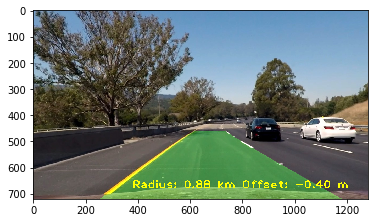

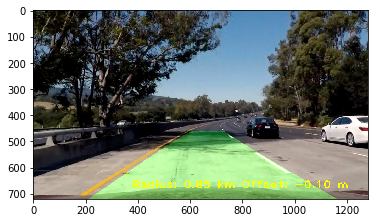

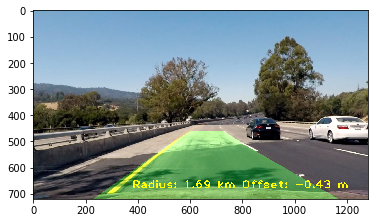

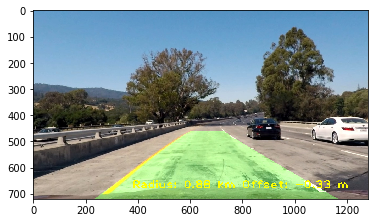

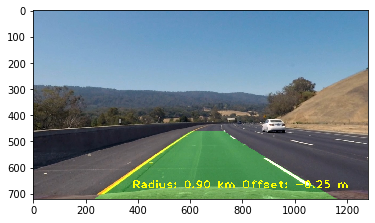

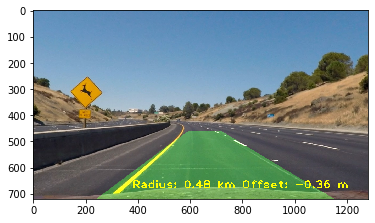

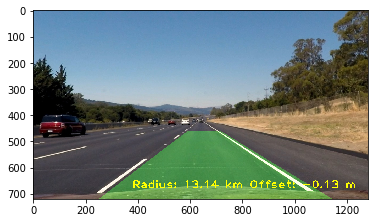

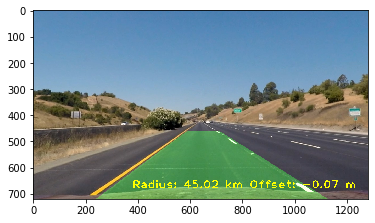

In [23]:
# test images
M, Minv = get_homography()
test_images = glob.glob("test_images/*.jpg")
for fname in test_images:
    image = read_image(fname)
    result = run_pipeline(image)
    plt.figure()
    plt.imshow(result)
    
    

In [24]:
def process_image(image):
    #images.append(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = run_pipeline(image, look_ahead = True)
    return result

In [28]:
white_output = 'output_images/output_project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 3/1260 [00:00<00:59, 21.11it/s, now=None]

Moviepy - Building video output_images/output_project_video.mp4.
Moviepy - Writing video output_images/output_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/output_project_video.mp4
CPU times: user 5min 51s, sys: 33.7 s, total: 6min 25s
Wall time: 1min 34s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))